In [64]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [65]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

import nfp

In [66]:
df = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/20210216_fixed_rl_redox_data.csv')
df.head()

,ionization energy,electron affinity,err_smiles,smiles
0,0.913684,-0.292055,C#CC1=C(C(C)C)C(C2CC2)=C([O])CC1,C#CC1=C(C(C)C)C(C2CC2)=C([O])CC1
1,1.066037,-0.326042,C#C[CH]C(C)=C(C(=O)O)C(C)(C)C,C#C[CH]/C(C)=C(\C(=O)O)C(C)(C)C
2,NaN,-0.382259,CC(=C(C=C([O])O)C(C)(C)C)C(C)(C)C,C/C(=C(/C=C(\[O])O)C(C)(C)C)C(C)(C)C
3,0.844432,-0.547755,CC(=C(C(O)=C[O])C(C)(C)C)C(C)(C)C,C/C(=C(C(/O)=C/[O])\C(C)(C)C)C(C)(C)C
4,0.843045,-0.576871,CC(=C(C(O)=C[O])C(C)(C)C)C(C)C,C/C(=C(C(/O)=C/[O])\C(C)(C)C)C(C)C


In [67]:
import sys
sys.path.append('..')

from rdkit import Chem
from alphazero.preprocessor import preprocessor

redox_model_orig = tf.keras.models.load_model(
    '/projects/rlmolecule/pstjohn/models/20210214_redox/',
    compile=False)

dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(Chem.MolFromSmiles(smiles), train=False)
             for smiles in df.smiles),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

new_preds_with_orig_data = redox_model_orig.predict(dataset, verbose=1)

29/29 [==============================] - 2s 82ms/step


In [68]:
# The original model predictions aren't super trustworthy, so we repredict with a model
# trained on only the original data, and down-select again for those that slightly cross
# the decision thresholds
df['pred ionization energy'] = new_preds_with_orig_data[:, 0]
df['pred electron affinity'] = new_preds_with_orig_data[:, 1]

df['V_diff_pred'] = df['pred ionization energy'] - df['pred electron affinity']

df_pred_pass = df[(df['pred electron affinity'] > -.5) &
        (df['pred ionization energy'] < 1.2) &
        (df['V_diff_pred'] > 1)]

print(f"fraction passing: {len(df_pred_pass) / len(df):.3f}")

df = df_pred_pass.copy()

fraction passing: 0.755


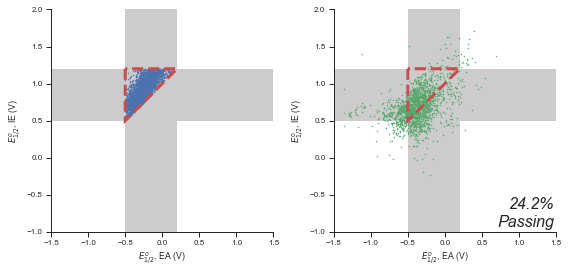

In [69]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, aspect='equal')

ax1.plot(df['pred electron affinity'], df['pred ionization energy'], '.', ms=1, rasterized=True)
ax1.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax1.set_xlim([-1.5, 1.5])
ax1.set_ylim([-1, 2])

ax1.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax1.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax1.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax1.set_ylabel(r'$E_{1/2}^o$, IE (V)')

ax2 = fig.add_subplot(122, aspect='equal')
ax2.plot(df['electron affinity'], df['ionization energy'], '.', ms=1, color='g', rasterized=True)
ax2.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax2.set_xlim([-1.5, 1.5])
ax2.set_ylim([-1, 2])

ax2.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax2.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax2.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax2.set_ylabel(r'$E_{1/2}^o$, IE (V)')

df['V_diff'] = df['ionization energy'] - df['electron affinity']
df_pass = df[(df['electron affinity'] > -.5) &
        (df['ionization energy'] < 1.2) &
        (df['V_diff'] > 1)]

ax2.text(.99, .01, f'{df_pass.shape[0] / df.shape[0]:.1%}\nPassing', ha='right', va='bottom', transform=ax2.transAxes, fontsize='16', style='italic')

sns.despine()
plt.tight_layout()
# plt.savefig('redox_dft_confirmation.svg')

In [70]:
df_pass.shape[0] / df.dropna(subset=['V_diff']).shape[0]

0.3918840579710145

In [71]:
df_spin = pd.read_csv('20210109_dft_ml_spin_bv_data.csv.gz')
df_spin = df_spin.merge(df, left_on='smiles', right_on='err_smiles', how='inner').drop(
    'smiles_x', 1).rename(columns={'smiles_y': 'smiles'})
df_spin.head()

,buried_vol,pred buried_vol,fractional_spin,pred fractional_spin,atom_index,ionization energy,electron affinity,err_smiles,smiles,pred ionization energy,pred electron affinity,V_diff_pred,V_diff
0,40.057887,37.746520,0.085155,0.130998,0,1.001031,NaN,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,0.846526,-0.269013,1.115539,NaN
1,54.431655,53.257458,0.024316,0.055328,1,1.001031,NaN,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,0.846526,-0.269013,1.115539,NaN
2,41.549793,40.567318,0.009385,0.004386,2,1.001031,NaN,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,0.846526,-0.269013,1.115539,NaN
3,32.768445,32.566360,0.001184,0.002064,3,1.001031,NaN,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,0.846526,-0.269013,1.115539,NaN
4,62.511166,63.582790,0.345404,0.263097,4,1.001031,NaN,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,0.846526,-0.269013,1.115539,NaN


In [72]:
def get_atom_symbols():
    for smiles in df_spin.smiles.unique():
        mol = rdkit.Chem.MolFromSmiles(smiles)
        for i, atom in enumerate(mol.GetAtoms()):
            yield pd.Series({
                'smiles': smiles,
                'atom_index': i,
                'atom_symbol': atom.GetSymbol()})

In [73]:
atom_symbol_df = pd.DataFrame(get_atom_symbols())

In [74]:
df_spin_symbol = df_spin.merge(atom_symbol_df, on=['smiles', 'atom_index'])

In [75]:
(df_spin_symbol.groupby('smiles').fractional_spin.idxmax() == df_spin_symbol.groupby('smiles')['pred fractional_spin'].idxmax()).mean()

0.8348880597014925

In [76]:
bur_vol_dft = df_spin_symbol.groupby('smiles').apply(lambda x: x.loc[x.fractional_spin.idxmax()].buried_vol)
bur_vol_ml = df_spin_symbol.groupby('smiles').apply(lambda x: x.loc[x['pred fractional_spin'].idxmax()][' pred buried_vol'])

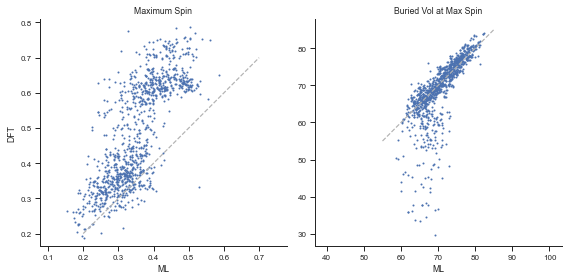

In [77]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, aspect='equal', adjustable='datalim')

ax1.plot(
    df_spin_symbol.groupby('smiles')['pred fractional_spin'].max(),
    df_spin_symbol.groupby('smiles').fractional_spin.max(),
    '.', ms=2)

ax1.plot([.2, .7], [.2, .7], '--', color='.7')

ax2 = fig.add_subplot(122, aspect='equal', adjustable='datalim')
ax2.plot(bur_vol_ml, bur_vol_dft, '.', ms=2)

ax2.plot([55, 85], [55, 85], '--', color='.7')
ax1.set_ylabel('DFT')
ax1.set_xlabel('ML')
ax2.set_xlabel('ML')

ax1.set_title('Maximum Spin')
ax2.set_title('Buried Vol at Max Spin')


sns.despine()
plt.tight_layout()

In [78]:
def stability_score(x): 
    idxmax = x['fractional_spin'].idxmax()
    spin = x['fractional_spin'].max()
    bur_vol = x.loc[idxmax]['buried_vol']
    
    score_dft = bur_vol + 50 * (1 - spin)
    
    idxmax = x['pred fractional_spin'].idxmax()
    spin = x['pred fractional_spin'].max()
    bur_vol = x.loc[idxmax][' pred buried_vol']
    
    score_pred = bur_vol + 50 * (1 - spin)
    return pd.Series({'dft': score_dft, 'pred': score_pred})

stability_scores = df_spin_symbol.groupby('smiles').apply(stability_score)

In [79]:
redox_data = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz')

In [80]:
redf_baseline = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/20210118_bde_baseline_spin_burvol.csv.gz')

def stability_score(x): 
    idxmax = x['fractional_spin'].idxmax()
    spin = x['fractional_spin'].max()
    bur_vol = x.loc[idxmax]['buried_vol']
    return bur_vol + 50 * (1 - spin)

bde_db_stability_scores = redf_baseline.groupby('smiles').apply(stability_score)

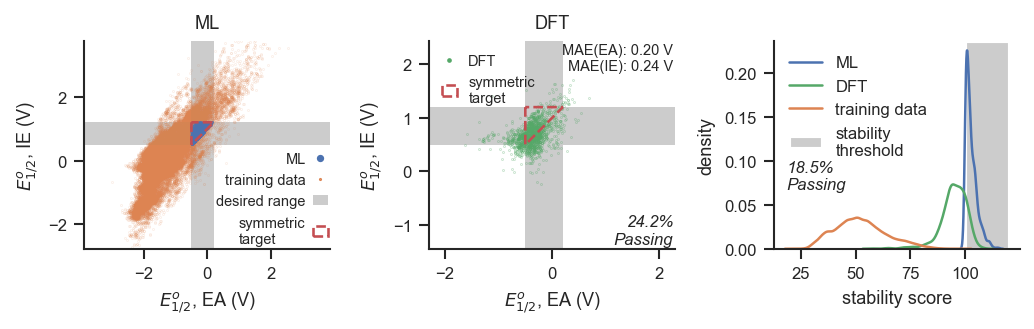

In [81]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(7,2.3), dpi=150)
ax1 = fig.add_subplot(131, aspect='equal', adjustable='datalim')

ax1.plot(df['pred electron affinity'], df['pred ionization energy'], '.', ms=.5, rasterized=True, color='b', zorder=3, label='ML')
ax1.plot(redox_data['electron affinity'], redox_data['ionization energy'], '.', ms=.1, rasterized=True, color=sns.color_palette()[1], zorder=1, label='training data')

ax1.set_xlim([-3, 3])
ax1.set_ylim([-2, 3])

ax1.axvspan(-.5, .2, facecolor='.8', edgecolor='none', zorder=0, label='desired range')
ax1.axhspan(.5, 1.2, facecolor='.8', edgecolor='none', zorder=0)

ax1.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax1.set_ylabel(r'$E_{1/2}^o$, IE (V)')

ax1.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=1.25, ls='--', label='symmetric\ntarget'))

ax1.legend(loc='lower right', markerfirst=False, markerscale=10, fontsize=7, borderpad=0, borderaxespad=0.2, handlelength=1, handletextpad=.5)

ax2 = fig.add_subplot(132, aspect='equal', adjustable='datalim')

df_nona = df.dropna(subset=['ionization energy', 'electron affinity'])
ax2.plot(df['electron affinity'], df['ionization energy'], '.', ms=.25, color='g', rasterized=True, zorder=3, label='DFT')

ax2.axvspan(-.5, .2, facecolor='.8', edgecolor='none', zorder=0)
ax2.axhspan(.5, 1.2, facecolor='.8', edgecolor='none', zorder=0)


ax2.set_xlim([-3, 3])
ax2.set_ylim([-2, 3])

ax2.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax2.set_ylabel(r'$E_{1/2}^o$, IE (V)')

# ax2.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
# ax2.yaxis.offsetText.set_visible(False)


ax2.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=1.25, ls='--', label='symmetric\ntarget'))

df['V_diff'] = df['ionization energy'] - df['electron affinity']
df['pass_redox'] = ((df['electron affinity'] > -.5) &
                    (df['ionization energy'] < 1.2) &
                    (df['V_diff'] > 1))

df_pass = df[df.pass_redox]

df_with_stability = df.merge(stability_scores, left_on='smiles', right_index=True)

ax2.text(.99, .01, f'{df_pass.shape[0] / df.shape[0]:.1%}\nPassing', ha='right', va='bottom', transform=ax2.transAxes, fontsize='8', style='italic')


ax2.text(.99, .99, f"MAE(EA): {(df['pred electron affinity'] - df['electron affinity']).abs().mean():.2f} V\n"
         f"MAE(IE): {(df['pred ionization energy'] - df['ionization energy']).abs().mean():.2f} V",
         ha='right', va='top', fontsize='7', transform=ax2.transAxes, )
# ax2.text(.99, .99, f", ha='right', va='top', fontsize='7', transform=ax2.transAxes, )

ax2.legend(loc='upper left', handlelength=1, markerscale=10, fontsize=7)


ax3 = fig.add_subplot(133)
sns.kdeplot(stability_scores['pred'], color='b', label='ML')
sns.kdeplot(stability_scores['dft'], color='g', label='DFT')
sns.kdeplot(bde_db_stability_scores, color=sns.color_palette()[1], label='training data')

# ax3.axvline(100, ls='--', color='r', lw=1.5)
ax3.axvspan(100, 120, facecolor='.8', lw=1.5, label='stability\nthreshold')

ax3.legend(loc='upper left')


ax3.text(.05, .35, f"{(stability_scores['dft'] > 100).mean():.1%}\nPassing",
         ha='left', va='center', transform=ax3.transAxes, fontsize='8', style='italic')

ax3.set_xticks([25, 50, 75, 100,])

plt.ylabel('density')
plt.xlabel('stability score')

ax1.set_title('ML')
ax2.set_title('DFT')

sns.despine()
plt.tight_layout()
plt.savefig('fig4_dft_confirmation.svg')

In [ ]:
(df_with_stability[df_with_stability['pass_redox'] & (df_with_stability.dft > 100)]).shape[0] / df_with_stability.shape[0]

In [ ]:
df_confirmed = df_with_stability[df_with_stability['pass_redox'] & (df_with_stability.dft > 100)]

In [ ]:
df_confirmed.to_csv('dft_confirmed.csv', index=False)